In [32]:
import os
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
group0_data = pd.read_csv("group0_station.csv")
stations = group0_data["group0_station"].tolist()
stations.append("day_of_week")

In [3]:
data_files = []
for (_, _, f) in os.walk("data/"):
    data_files.extend(f)
    break

data_files.sort()
print(data_files)

['201811_en.ods', '201911_en.ods', '201912_en.ods', '202001_en.ods', '202002_en.ods', '202003_en.ods', '202004_en.ods', '202005_en.ods', '202006_en.ods', '202007_en.ods', '202008_en.ods', '202009_en.ods', '202010_en.ods', '202011_en.ods', '202012_en.ods', '202101_en.ods', '202102_en.ods', '202103_en.ods', '202104_en.ods', '202105_en.ods', '202106_en.ods', '202107_en.ods', '202108_en.ods', '202109_en.ods', '202110_en.ods', '202111_en.ods', '202112_en.ods', '202201_en.ods', '202202_en.ods', '202203_en.ods', '202204_en.ods', '202205_en.ods', '202206_en.ods', '202207_en.ods', '202208_en.ods', '202209_en.ods', '202210_en.ods', '202211_en.ods']


In [4]:
dayofweek_summary_data_ = pd.DataFrame()

for file in data_files[3:]:
    data_ = pd.read_excel(f"data/{file}", engine="odf", index_col=None)
    data_.rename(columns={"            StationDate": "StationDate"}, inplace=True)
    data_["day_of_week"] = data_['StationDate'].dt.day_name()

    data_ = data_[[s for s in data_.columns if s in stations]]
    dayofweek_data_ = data_.groupby("day_of_week").agg("mean")
    dayofweek_data_ = dayofweek_data_.reindex(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]).transpose()
    dayofweek_data_["year_month"] = file.split(".")[0].split("_")[0]

    dayofweek_data_.reset_index(inplace=True)

    dayofweek_summary_data_ = pd.concat([dayofweek_summary_data_, dayofweek_data_], axis=0)

print(dayofweek_summary_data_.shape)


(700, 9)


In [5]:
dayofweek_summary_data = dayofweek_summary_data_.sort_values(["index", "year_month"]).reset_index(drop=True)
dayofweek_summary_data.to_csv("results/dayofweek_summary_data.csv")

In [6]:
long_dayofweek_summary_data = pd.melt(dayofweek_summary_data, id_vars=["index", "year_month"], 
                                      value_vars=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])

long_dayofweek_summary_data = long_dayofweek_summary_data.sort_values(["index", "year_month"]).reset_index(drop=True)

In [7]:
long_dayofweek_summary_data.columns

Index(['index', 'year_month', 'day_of_week', 'value'], dtype='object')

In [45]:

# plt.figure(figsize=(15, 15))
# sns.boxplot(
#     data=long_dayofweek_summary_data,
#     x="value", y="index", hue="day_of_week"
# )
# plt.legend()
# plt.show()


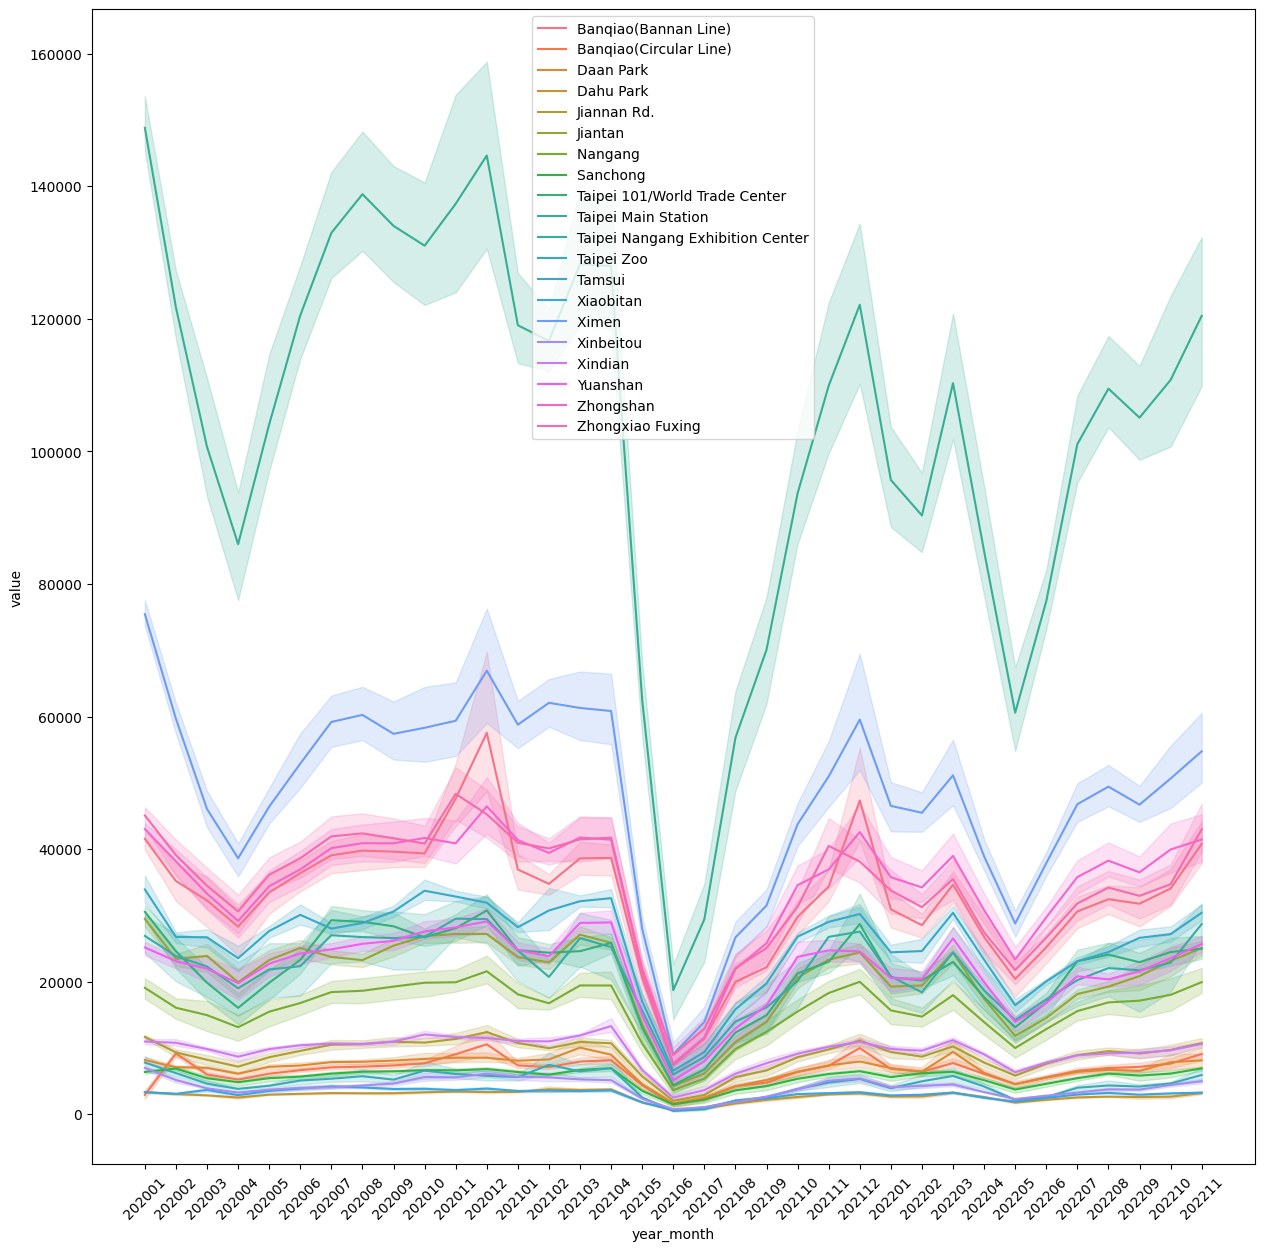

In [9]:
plt.figure(figsize=(15, 15))
sns.lineplot(
    data=long_dayofweek_summary_data,
    x="year_month", y="value", hue="index",
    markers=True
)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [18]:
long_dayofweek_summary_data["seriously_outbreak_202106"] = ["before" if time < "202106" else "after" for time in long_dayofweek_summary_data["year_month"]]

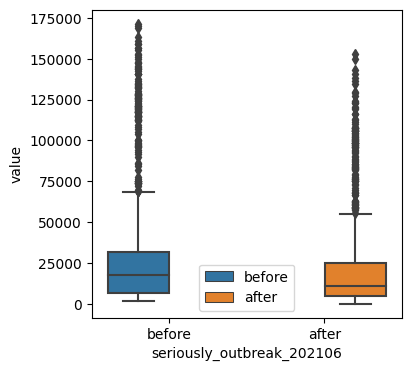

In [50]:
plt.figure(figsize=(4, 4))
sns.boxplot(
    data=long_dayofweek_summary_data,
    x="seriously_outbreak_202106", y="value", hue="seriously_outbreak_202106"
)
plt.legend()
plt.show()

In [34]:
before2020106 = long_dayofweek_summary_data[long_dayofweek_summary_data["year_month"] < "202106"]
after2020106 = long_dayofweek_summary_data[long_dayofweek_summary_data["year_month"] > "202106"]

In [42]:
## perform normal distribution test: reject
print(scipy.stats.shapiro(before2020106["value"]), scipy.stats.shapiro(after2020106["value"]))

ShapiroResult(statistic=0.7110626101493835, pvalue=0.0) ShapiroResult(statistic=0.7251564860343933, pvalue=0.0)


In [46]:
## perform non-paramtric way
before_after_kw = scipy.stats.kruskal(before2020106["value"], after2020106["value"])
before_after_kw.pvalue

5.883913613624046e-17

In [38]:
print(before2020106["value"].median(), after2020106["value"].median())

17696.375 12551.625


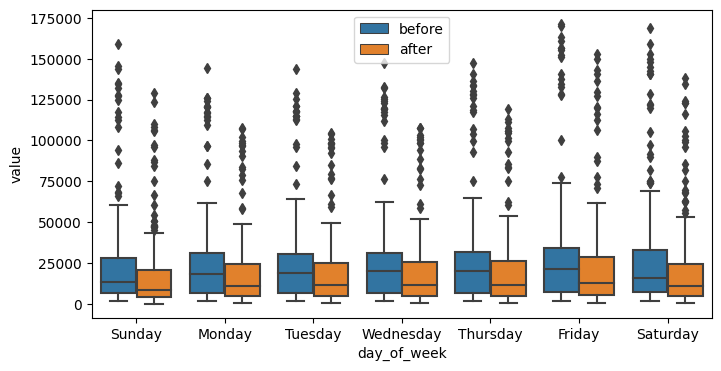

In [48]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=long_dayofweek_summary_data,
    x="day_of_week", y="value", hue="seriously_outbreak_202106"
)
plt.legend()
plt.show()

In [47]:
dayofweek = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
for day in dayofweek:
    day_kw = scipy.stats.kruskal(before2020106[before2020106["day_of_week"] == day]["value"],
                                 after2020106[after2020106["day_of_week"] == day]["value"])
    print(f"{day} median test p-value: {day_kw.pvalue}")

Sunday median test p-value: 0.00010561539930639142
Monday median test p-value: 0.0007375446586471268
Tuesday median test p-value: 0.0007480780415014862
Wednesday median test p-value: 0.0018999341528503197
Thursday median test p-value: 0.003858071643793506
Friday median test p-value: 0.008394847876646613
Saturday median test p-value: 0.0006933082694192111
